# Floyrac Aymeric et Ané Benoit, Projet Python 2A ENSAE ParisTech

# Détection d'anomalies cardiaques à partir d'enregistrements sonores de battements de coeur par phonocardiogramme

Notre projet Python s'inspire du Challenge Physionet 2016 (https://physionet.org/). Ce site propose des compétitions tous les ans sur le thème de l'analyse de signaux physiologiques en OpenSource. <br>
En 2016, un ensemble d'enregistrements sonores de battements de coeur d'individus par phonocardiogramme ont été fournis aux candidats afin de construire un modèle prédictif pour déterminer si le coeur enregistré est sain ou malade (c'est-à-dire, s'il bat de façon normal ou non). Les données ont été récoltées par 7 équipes différentes (ce qui évite tout "effet centre", ie tout biais lié à la méthode d'enregistrement), et proviennent de patients sains ou bien atteints de maladies diverses comme une maladie coronarienne, une déformation de la valve aortique ou encore un problème du souffle au coeur. <br>
Notre objectif était de construire un ensemble de variables explicatives à partir d'une base constituée des signaux bruts afin de bâtir un modèle de Machine Learning.  
Au préalable, un travail de recherche bibliographique a été necessaire afin de se familiariser avec le vocabulaire du sujet, connaître la méthodologie de pre-processing à appliquer aux signaux, trouver les features à extraire ainsi que les modèles ayant déjà été appliqués dans des problématiques similaires. L'ensemble des articles que nous avons consultés dans ce but sont renseignés en fin de projet dans la bibliographie.  

Nous pouvons présenter notre travail à travers 5 étapes majeures :  

1) La conversion des enregistrements sonores en matrices exploitables <br> 
2) Notre algorithme qui traite un signal brut pour faciliter la segmentation et l'extraction des variables explicatives. Nous présentons des graphiques afin d'illustrer les étapes principales de notre algorithme de segmentation <br> 
3) La création et l'analyse des features <br> 
4) La construction des modèles prédictifs de Machine Learning  <br> 
5) Notre commentaire et conclusion sur le travail effectué  <br> 

In [135]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Conversion des enregistrements sonores en matrices

L'objectif de cette partie est de convertir les enregistrements sonores en matrice exploitable pour notre algorithme. Pour des raisons de puissance et de temps de calcul, nous n'allons pas prendre l'ensemble de la base proposée par PhysioNet, mais seulement une partie. 

In [1]:
import wave, os, glob
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [3]:
def createDf(folder_path):
    res = pd.DataFrame([])
    for filename in glob.glob(os.path.join(folder_path, '*.wav')):
        fs, data = wavfile.read(filename)
        df = pd.DataFrame(data)
        df = df.transpose()
        res = res.append(df)
        del data, fs
    return res

Nous allons regrouper tous les dossiers dans la même base de données, que nous découperons plus tard en base de test et base d'entraînement.

In [82]:
df_a = createDf('training-a')
df_b = createDf('training-b')
df_c = createDf('training-c')
df_d = createDf('training-d')
df_f = createDf('training-f')

In [ ]:
df_abcdf = df_a.append([df_b,df_c,df_d,df_f],ignore_index=True)

In [ ]:
np.save('training_abcdf.npy',df_abcdf,allow_pickle=True)

Nous donnons une représentation graphique d'un des signaux tel que nous avons pu l'observer une fois la conversion effectuée

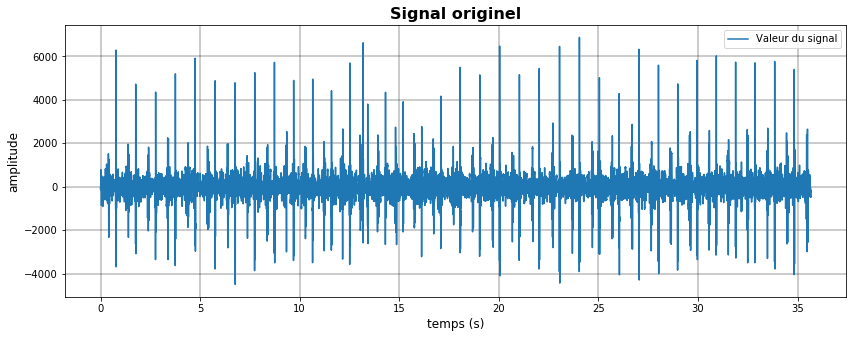

In [6]:
exemple = df_abcdf[0]
l = len(exemple)
x = np.linspace(0,l/2000,l)
plt.figure(figsize=(14,5),facecolor="w")
plt.plot(x, exemple,label = "Valeur du signal")
plt.title("Signal originel",fontsize=16,fontweight='semibold')
plt.xlabel('temps (s)',fontsize=12)
plt.ylabel('amplitude',fontsize=12)
plt.grid(color='k', linewidth=.4)
ax = plt.gca()
ax.set_facecolor('xkcd:white')
plt.grid(True)
plt.legend()
plt.show()

## 2. Traitement des signaux

### 2.1 Importation de la base


In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import wave, os, glob
import pandas as pd
import numpy as np
from scipy.io import wavfile
from itertools import accumulate

In [136]:
mat_abcdf = np.load('training_abcdf.npy')

On constitue la base de labels

In [6]:
labels_a = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_b = pd.read_csv('training-b/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_c = pd.read_csv('training-c/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_d = pd.read_csv('training-d/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_f = pd.read_csv('training-f/REFERENCE.csv',header=None,names=['filename','label'])['label']

labels = np.concatenate((labels_a,labels_b,labels_c,labels_d,labels_f))

### 2.2 Plan de la classe PCG

In [137]:
from scipy.signal import find_peaks, welch
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft,fftfreq
from librosa.feature import mfcc

Nous pouvons à présent procéder à la présentation de notre algorithme. Nous avons choisi de créer une classe, PCG (pour phonocardiogramme), dont les fonctions permettront de traiter les signaux et d'extraire les caractéristiques des signaux qui nous intéressent.  
Nous avons appris lors de nos recherches que les battements d'un coeur se décomposent en 4 phases et dans l'odre suivant : S1, systole, S2 et diastole. L'image ci-dessous illustre ce point. Notre objectif est donc d'aboutir à une segmentation telle qu'elle est représenter sur le schéma ci-dessous. En délimitant chaque phase, nous pourrons construire des features pour chacune d'entre elles. 

<img src="battement.png">

In [138]:
#liste des phases
phases_list = ['S1','S2','systole','diastole']

Nous précisons également, en plus des remarques incorporées dans le code, l'ensemble des fonctions que nous avons créées. Elles sont décrites ci-dessous. Nous avons également réalisé des graphiques (voir la partie 2.3, illustration du processus) pour permettre au lecteur de mieux visualiser chacune des étapes.

1) __init__ : Nous centrons le signal considéré. Nous avons utilisé la formule classique : $$s_{centré} = s - \bar{s}$$  Ce procédé permet de supprimer le bruit de fond du signal, et constitue une première étape de nettoyage. <br>

2) __envelogram__ : Calcul de l'envelogramme du signal auquel on applique un seuil pour débruiter le signal. Le seuil appliqué est la valeur du maximum local sur 5. Nous calculons l'envelogramme à partir de l'énergie de Shannon du signal centré. L' énergie est calculée grâce à la formule suivante :  $$E = -s(t)^{2}.log(s(t)^{2}) $$ où $s(t)$ est le signal (recentré) à un moment $t$  


3) __consec_count__ : On compte le nombre d'occurence d'une même valeur. Cette fonction sera déterminante pour segmenter les phases d'un cycle cardiaque  
4) __segmentation__ : On segmente le signal en différentes phases  
5) __timelengths__ : On détermine la durée de chaque phase  
6) __timefeatures__ : On détermine les durées de chaquephase du signal  
7) __computeborne__ : On détermine les bornes temporelles de chaque phase sur le signal entier afin de pouvoir calculer des valeurs sur chacune d'entre elles  
8) __moments__ : On détermine pour chaque phase le l'aplatissement et l'asymétrie du signal  
9) __computeMFCC__ : "Mel-frequency cepstral coefficients" sont dérivés de l'analyse spectral d'un signal audio  
10) __extractFeatures__ : On extrait l'ensemble de nos features calculés à partir des fonctions précédentes dans un vecteur par signal traité  

Des notes sont présentes dans le code pour accompagner le lecteur dans sa compréhension du code

In [139]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)]) #on ignore les NaN 
        self.signal = self.signal - np.mean(self.signal) #on recentre
        self.normalized_signal = self.signal/np.std(self.signal)
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        #E = E/np.std(E)
        E = -1*(E**2) * np.log(E**2)

        #on met les petites valeurs à 0 
        # il faut d'abord calculer les maximums locaux 
        window_length = 750
        local_max = np.array([np.max(E[i-window_length:i+window_length]) for i in range(window_length,len(E)-window_length)])
        local_max = np.concatenate((local_max[0]*np.ones(window_length),local_max,local_max[-1]*np.ones(window_length)))
        s = np.std(E)
        m = np.mean(E)
        #On définit un seuil à appliquer à l'énergie de shannon
        mask = E>local_max/5
        return E*mask
    
    
    def consec_count(self):
        e = self.envelogram()
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segmentation(self):
        E = self.envelogram()
        count_vec = self.consec_count() # le vecteur de comptage associé
        length_threshold = 50
        beat_mask = count_vec<=length_threshold
        systole_mask = count_vec>length_threshold
        segmentation = np.asarray([])
        mean_beat_length = 0
        beat_counter = 0
        counters = {'S1':0,'S2':0}
        i = 0
        while i<count_vec.shape[0]:
            stop = i 
            next_stop = i
            while stop < count_vec.shape[0] and next_stop-stop<0.050*self.fs:
                stop = next_stop
                #on calcule la longueur du pic
                while stop<count_vec.shape[0] and beat_mask[stop]:
                    stop+=1

                #on calcule l'écart avec le pic suivant, pour voir s'il s'agit du même pic
                next_stop = stop
                while next_stop<count_vec.shape[0] and not beat_mask[next_stop]:
                    next_stop +=1
                
            #un battement long est un battement S1
            if stop-i>mean_beat_length:
                segmentation = np.concatenate((segmentation,np.repeat('S1',stop-i)))
                counters['S1'] += 1
                current_seq = {'beat':'S1','passive':'systole'}
                
            #un battement court est un battement S2
            else:
                segmentation = np.concatenate((segmentation,np.repeat('S2',stop-i)))
                counters['S2'] += 1
                current_seq = {'beat':'S2','passive':'diastole'}
                
            #update beat length and parser
            mean_beat_length = np.average([stop-i,mean_beat_length],weights=[1,beat_counter])
            beat_counter += 1
            i = stop
                
            while stop<count_vec.shape[0] and systole_mask[stop]:
                stop+=1
                
            segmentation = np.concatenate((segmentation,np.repeat(current_seq['passive'],stop-i)))
            #update parser
            i = stop
        
        #on supprime tout ce qui est avant la première phase S1: 
        j = 0 
        while segmentation[j]!='S1':
            j += 1
            
        return segmentation[j:],E[j:],j,counters
    
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)[res!=0]
        if res.shape[0] == 0:
            return 0,0,0
        return np.mean(res),np.std(res),res.shape[0]
    
    def timeFeatures(self,segmentation):
        sysRR = [] #rapport durée systole/durée battement
        diaRR = [] #rapport durée diastole/durée battement
        sysdia = [] # rapport durée systole/durée diastole
        start = 0
        bound = len(segmentation)
        #on commence sur la première phase S1
        while segmentation[start]!='S1':
            start+=1
        #on parcourt toute la segmentation
        while start<bound:
            parser = start
            # on attend d'arriver à la première systole
            while parser<bound and segmentation[parser]!='systole':
                parser += 1
            psys = parser
            # on mesure la taille de la systole
            while psys<bound and segmentation[psys]=='systole':
                psys += 1
            systole_length = psys - parser
            parser = psys
            #on mesure la (les) diastole(s)
            diastole_length_list=[]
            while parser<bound and segmentation[parser]!='S1': #la fin du cycle est marquée par le début d'un nouveau S1
                while parser<bound and segmentation[parser]=='S2':#un S2 précède toujours une diastole
                    parser+=1
                pd = parser
                while pd<bound and segmentation[pd]=='diastole': #on mesure la diastole
                    pd += 1
                diastole_length_list.append(pd-parser)
                parser = pd
                
            #grandeurs extraites
            beat_length = parser - start
            sysRR.append(systole_length/beat_length)
            diaRR.append(sum(diastole_length_list)/beat_length)
            if sum(diastole_length_list)!=0:
                sysdia.append(systole_length/sum(diastole_length_list))
            #update start
            start = parser
        sysRR = np.array(sysRR)
        diaRR = np.array(diaRR)
        sysdia = np.array(sysdia)
        
        return np.nan_to_num([np.mean(sysRR),np.std(sysRR),np.mean(diaRR),np.std(diaRR),np.mean(sysdia),np.std(sysdia)])
   
    def computeBorne(self,segmentation):
        borne = [0]
        #On recupère l'index du changement de phase dans la segmentation calculée
        for i in range(1,len(segmentation)-1):
            if segmentation[i-1] != segmentation[i]:
                borne.append(i)
        borne.append(len(segmentation))
        return borne 
    
    def moments(self,segmentation,borne,phase,decalage):
        phase_skew = []
        phase_kurt = []
        #Pour chaque phase, on cherche l'asymétrie et l'aplatissement sur le segment déterminé par la fonction computeborne
        sig = self.signal[decalage:]
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == phase:
                interest_signal = sig[borne[i]:borne[i+1]]
                phase_skew.append(skew(interest_signal))
                phase_kurt.append(kurtosis(interest_signal))
        if len(phase_skew) == 0:#cas d'erreur
            return 0,0,0,0
        return np.array([np.mean(phase_skew),np.std(phase_skew),np.mean(phase_kurt),np.std(phase_kurt)])
    
    def computeMFCC(self,segmentation,borne,phase,decalage):
        mfcc_matrix = np.zeros(10)
        sig = self.signal[decalage:]
        #On utilise la même logique que dans moments() pour déterminer les MFCC features
        boolean = False
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == phase:
                boolean = True
                interest_signal = sig[borne[i]:borne[i+1]]
                mfccs = mfcc(interest_signal,sr=2000,n_mfcc=10)
                mfcc_matrix = np.row_stack((mfcc_matrix,np.mean(mfccs,axis=1)))
        if not boolean:#cas d'erreur
            return np.zeros(10)
        
        return  np.mean(mfcc_matrix[1:],axis=0)
        
    def extractFeatures(self):
        #Cette fonction va retourner un vecteur avec tous nos features pour chaque signal considéré
        segmentation, E,decalage,counters = self.segmentation()
        #ratio nombre de S1 par rapport au nombre de S2
        if counters['S2']!=0:
            features = np.array([counters['S1']/counters['S2']])
        else: #cas d'erreur
            features = np.zeros(1)
        
        #time features
        to_compute_ratio = []
        for phase in phases_list:
            mean,std,last = self.timeLengths(segmentation,phase)
            if phase == 'systole' or phase == 'diastole': #on aura en premier la systole 
                to_compute_ratio.append(last)
            features = np.append(features,[mean,std])
        features = np.append(features,np.nan_to_num(to_compute_ratio[0]/to_compute_ratio[1])) #durée de la systole sur la diastole
        mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia = self.timeFeatures(segmentation)
        features = np.concatenate((features,[mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia]))
        
        #calcul des bornes    
        p_S1 = []
        p_S2 = []
        borne = self.computeBorne(segmentation)
        
        #Skewness et Kurtosis
        for phase in phases_list:
            features = np.concatenate((features,self.moments(segmentation,borne,phase,decalage)))
        
        #mean12 feature
        features = np.append(features,max(features[2],features[5]))
        
        #Rapport d'amplitudes
        sig = self.signal[decalage:]
        amp_sys_s1 = []
        amp_dia_s2 = []
        
        for i in range(0,len(borne)-2):
            if (segmentation[borne[i]] == 'S1') & (segmentation[borne[i+1]] == 'systole') & (borne[i+2] != 0):
                amp_sys_s1.append(max(sig[borne[i+1]:borne[i+2]]) - min(sig[borne[i+1]:borne[i+2]])/max(sig[borne[i]:borne[i+1]]) - min(sig[borne[i]:borne[i+1]]))
            else :
                pass
        for i in range(0,len(borne)-2):
            if (segmentation[borne[i]] == 'S2') & (segmentation[borne[i+1]] == 'diastole') & (borne[i+2] != 0):
                amp_dia_s2.append(max(sig[borne[i+1]:borne[i+2]]) - min(sig[borne[i+1]:borne[i+2]])/max(sig[borne[i]:borne[i+1]]) - min(sig[borne[i]:borne[i+1]]) )
            else :
                pass
        if len(amp_sys_s1)==0:
            features = np.append(features,[0,0])
        else: 
            features = np.append(features,[np.mean(amp_sys_s1),np.std(amp_sys_s1)])
        if len(amp_dia_s2)==0:
            features = np.append(features,[0,0])
        else:
            features = np.append(features,[np.mean(amp_dia_s2),np.std(amp_dia_s2)])

        #spectral features
        frequency_bands = np.array([0,25,40,60,90,120,160,250,400])
        freqs, psd = welch(self.signal[decalage:],fs=2000)
        freqs, psd = np.asarray(freqs),np.asarray(psd)
        band_spectral_power = []
        for i in range(frequency_bands.shape[0]-1):
            mask = [freqs<frequency_bands[i+1]] and [freqs>frequency_bands[i]]
            band_spectral_power.append(np.sum(psd[mask]**2))
        features = np.append(features,band_spectral_power)
        
        #MFCC features
        for phase in phases_list:
            features = np.concatenate((features,self.computeMFCC(segmentation,borne,phase,decalage)))
        
        return features

### 2.3 Illustration du processus

Cette partie propose d'aider le lecteur à visualiser graphiquement les fonctions majeures qui nous ont permis d'extraire des variables exploitables dans un modèle prédictif. Nous avons décidé de prendre un signal au hasard mais la même méthode est appliqué à chaque signal considéré. 

In [140]:
time_length = 10000 #on visualise le signal sur 5 secondes

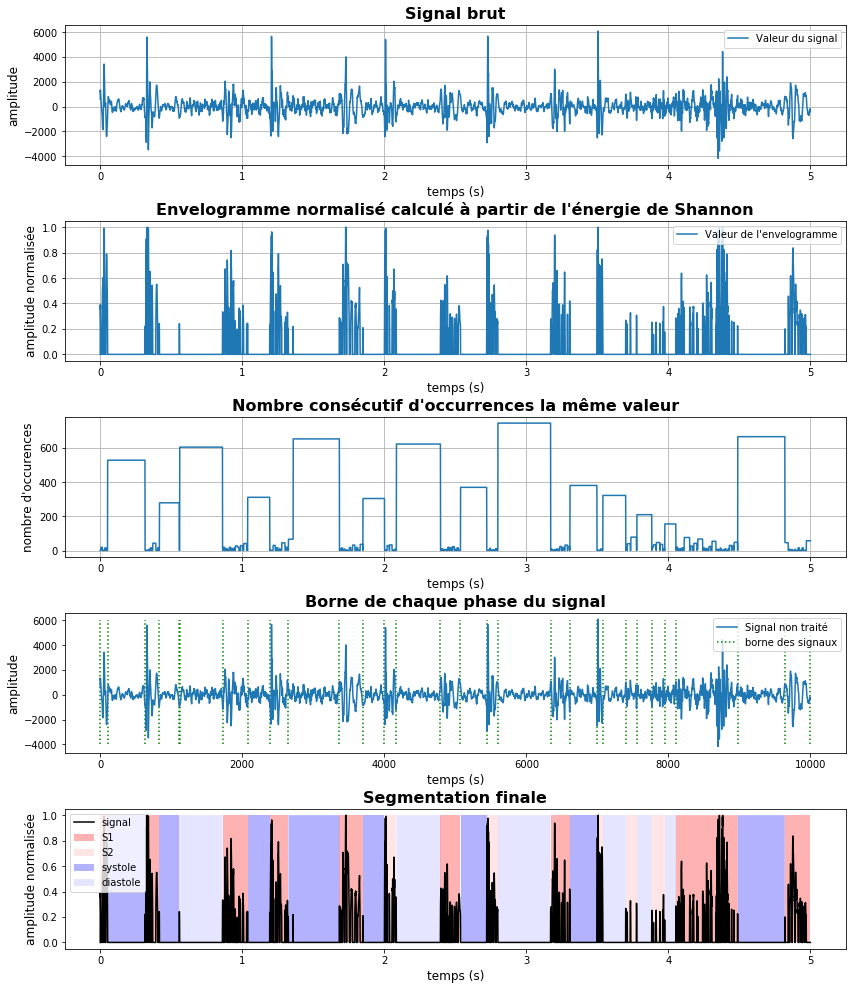

In [153]:
signal =  mat_abcdf[87][:time_length] #On considère ce signal
pcg = PCG(signal)
e = pcg.envelogram()
c = pcg.consec_count()
segmentation,e,lag,t = pcg.segmentation()
b = pcg.computeBorne(segmentation)
l = time_length-lag
x = np.linspace(0,l/2000,l)

fig = plt.figure(figsize=(14,17))
fig.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(511)
ax1.plot(x,signal, label = "Valeur du signal")
ax1.set_title("Signal brut",fontsize=16,fontweight='semibold')
ax1.set_xlabel('temps (s)',fontsize=12)
ax1.set_ylabel('amplitude',fontsize=12)
ax1.legend()
ax1.grid(True)


ax2 = fig.add_subplot(512)
ax2.plot(x,e/np.max(e), label = "Valeur de l'envelogramme")
ax2.set_title("Envelogramme normalisé calculé à partir de l'énergie de Shannon",fontsize=16,fontweight='semibold')
ax2.set_xlabel('temps (s)',fontsize=12)
ax2.set_ylabel('amplitude normalisée',fontsize=12)
ax2.legend()
ax2.grid(True)

ax3 = fig.add_subplot(513)
ax3.plot(x,c)
ax3.set_title("Nombre consécutif d'occurrences la même valeur",fontsize=16,fontweight='semibold')
ax3.set_xlabel('temps (s)',fontsize=12)
ax3.set_ylabel('nombre d\'occurences',fontsize=12)
ax3.grid(True)

ax4 = fig.add_subplot(514)
ax4.plot(signal, label = "Signal non traité")
ax4.vlines(b,-4000,6000, colors='g', linestyle='dotted',label = 'borne des signaux')
ax4.set_title("Borne de chaque phase du signal",fontsize=16,fontweight='semibold')
ax4.set_xlabel('temps (s)',fontsize=12)
ax4.set_ylabel('amplitude',fontsize=12)
ax4.legend()


ax5 = fig.add_subplot(515)
ax5.fill_between(x,0,1,where = segmentation=='S1',facecolor='r',alpha=.3,label='S1')
ax5.fill_between(x,0,1,where = segmentation=='S2',facecolor='r',alpha=.1,label='S2')
ax5.fill_between(x,0,1,where = segmentation=='systole',facecolor='b',alpha=.3,label='systole')
ax5.fill_between(x,0,1,where = segmentation=='diastole',facecolor='b',alpha=.1,label='diastole')
ax5.set_title("Segmentation finale",fontsize=16,fontweight='semibold')
ax5.set_xlabel('temps (s)',fontsize=12)
ax5.set_ylabel('amplitude normalisée',fontsize=12)
ax5.plot(x,e/np.max(e),'k',label='signal')
ax5.legend()



## 3. Analyse des features

Cette partie se décompose en deux temps. Tout d'abord, nous allons appliquer nos fonctions à l'ensemble des signaux afin de pouvoir en extraire les features. Par la suite nous présenterons les distributions de nos features selon si le coeur est sain ou non. La fonction extractFeatures() nous permet de constituer notre vecteur de features pour chaque signal. Nous fournissons également une liste exhautive des différentes catégories de features que nous avons pris en compte :  

- __variables temporelles__ : la moyenne et l'écart-type de la durée de chacune des phases au cours du signal, le maximum entre le temps moyenne de la diastole et de la systole, la moyenne et l'écart-type du ratio de la durée entre la systole et le temps d'un cycle cardiaque, entre la diastole et un cycle cardiaque et entre la systole et la diastole  

- __variables fréquentistes__ : La moyenne et l'écart-type du rapport d'amplitude entre la systole et S1 et entre la diastole et la S2

- __variables spectrales__: puissances spectrales (obtenues par transformée de Fourier) sur 8 bandes de fréquence

- __variables MFCC__ (coefficients cepstraux)

- __l'asymétrie__ (skewness) et __l'aplatissement__ (kurtosis) du signal pour chaque phase

Nous allons, à travers l'analyse des distributions des features, nous faire une idée de celles qui pourraient jouer un rôle dans la détection de battements de coeur anormaux. De plus, la comparaison entre les deux catégories de coeur nous permet d'avoir un retour supplémentaire sur la qualité de notre segmentation.

### 3.1 Calcul des features
Nous appliquons notre algorithme PCG à l'ensemble de nos signaux afin d'extraire une matrice avec un nombre de lignes égal aux nombre de signaux considérés et un nombre de colonnes égal au nombre de features. Nous rajouterons également "label", la variable à prédire, qui indique si le coeur est sain ou malade. Nous exporterons notre base finale au format .npz

In [12]:
start = time.time()
sample = mat_abcdf[408]
pcg = PCG(sample)
ft = pcg.extractFeatures()
end = time.time()
print('Pour un signal, le calcul des features a pris {} secondes'.format(round(end-start,2)))
ft.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:264: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Pour un signal, le calcul des features a pris 3.14 secondes


(85,)

In [13]:
n_samples = mat_abcdf.shape[0]

In [ ]:
X = np.zeros(85)
final_labels = []
for i in range(n_samples):
    try:
        sample = mat_abcdf[i]
        pcg = PCG(sample)
        ft = pcg.extractFeatures()
        X = np.row_stack((X,ft))
        final_labels.append(labels[i])
        
    except:
        print('il y a une erreur avec le sample {}'.format(i))
X = X[1:]

In [ ]:
np.savez('features_abcdf.npz',X,final_labels)

### 3.2 Visualisation de la distribution des features

Les histogrammes suivants représentent la répartition des feature extraites à travers la base de signaux. Ils permettront d'apprécier visuellement la significativité de ces features. Nous en avons calculé 85.

In [4]:
out = np.load('features_abcdf.npz')
dataset,labels = out['arr_0'],out['arr_1']

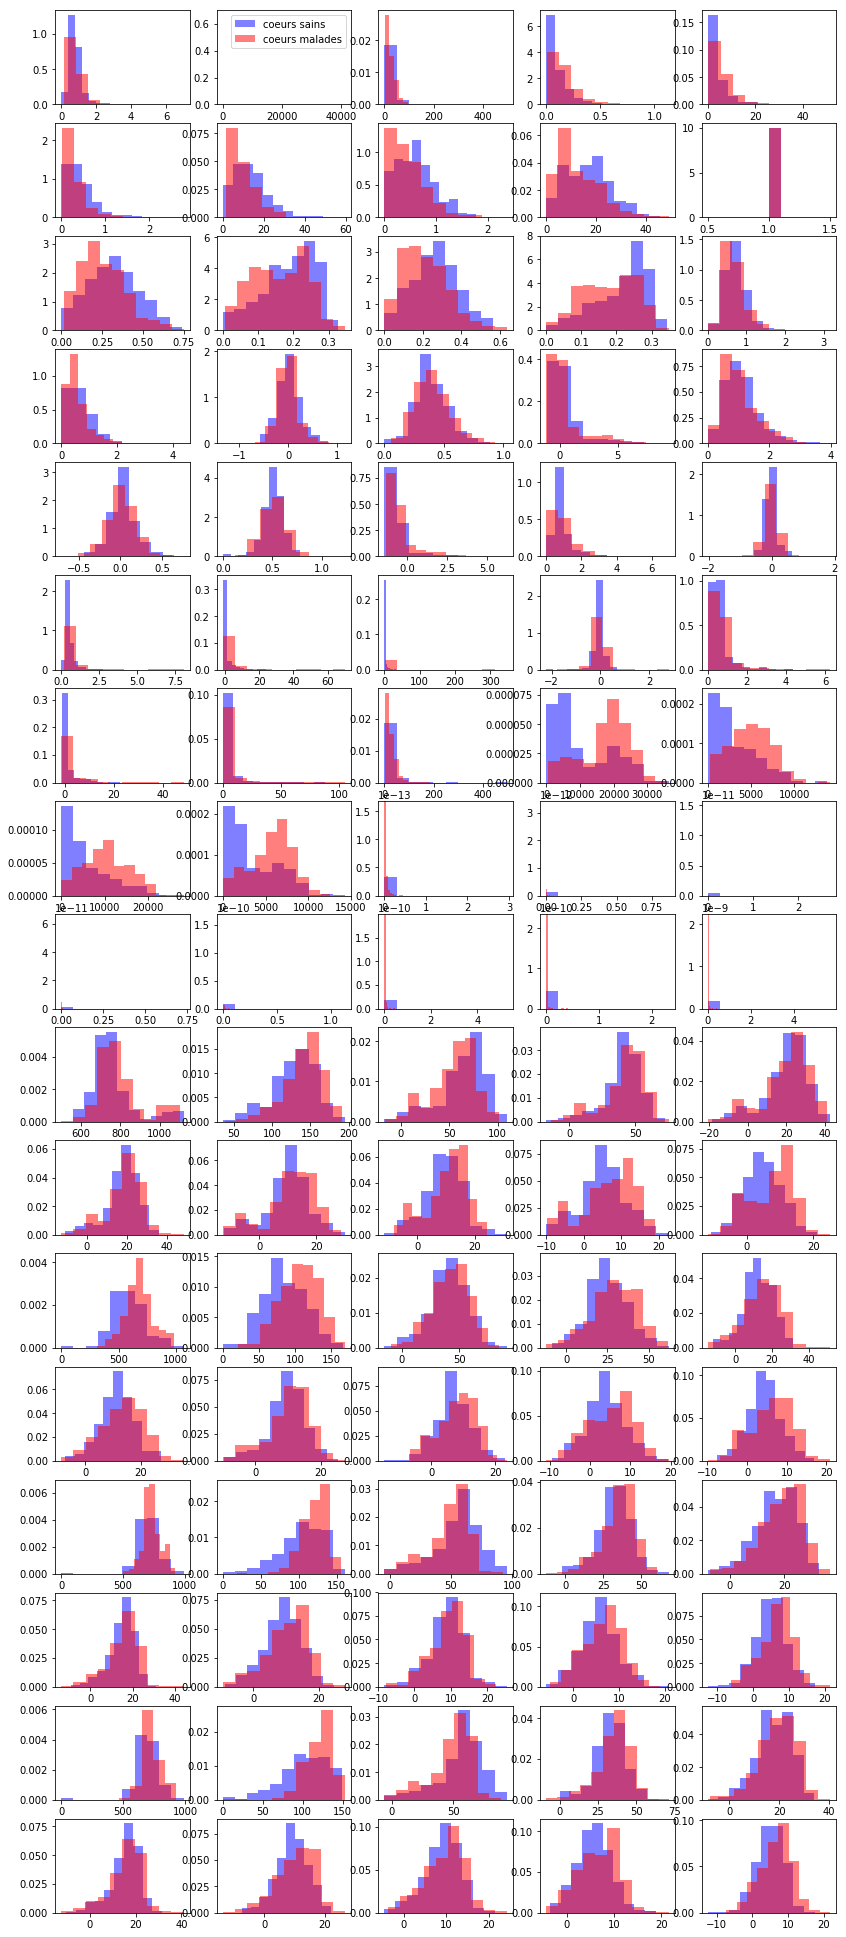

In [15]:
fig = plt.figure(figsize=(14,35))
for i in range(85):
    ax = fig.add_subplot(17,5,i+1)
    ft = dataset[:,i]
    normalft = ft[labels==1]
    anormalft = ft[labels==-1]
    ax.hist(normalft,density=True,color='b',alpha=0.5,label='coeurs sains')
    ax.hist(anormalft,density=True,color='r',alpha=0.5,label='coeurs malades')
    if i==1:
        ax.legend()

On remarque que, pour la plupart des features retenues, on observe bien deux distributions distinctes. <br> En revanche, certaines semblent inutiles, les deux distributions étant trop proches. Elles ne permettront pas une classification efficace. Cela motivera une *réduction de dimension* dans la suite du projet.

Regardons la matrice de corrélation de ces features

Text(0.5, 1.0, 'Matrice de corrélation')

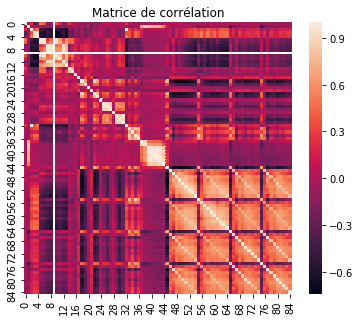

In [76]:
plt.figure(figsize=(6,5))
sns.heatmap(pd.DataFrame(dataset).corr())
plt.title('Matrice de corrélation',fontsize=12)

Les relations de corrélations entre les features ne sont pas claires. En revanche, on peut remarquer un bloc de variables relativement bien corrélées entre elles (bloc en bas à droite) qui sont en fait les features MFCC. Les features de puissance spectrale semblent aussi bien corrélées (bloc central).

Nous présentons également plusieurs boxplots de nos différents features afin de confirmer les intuitions des histogrammes

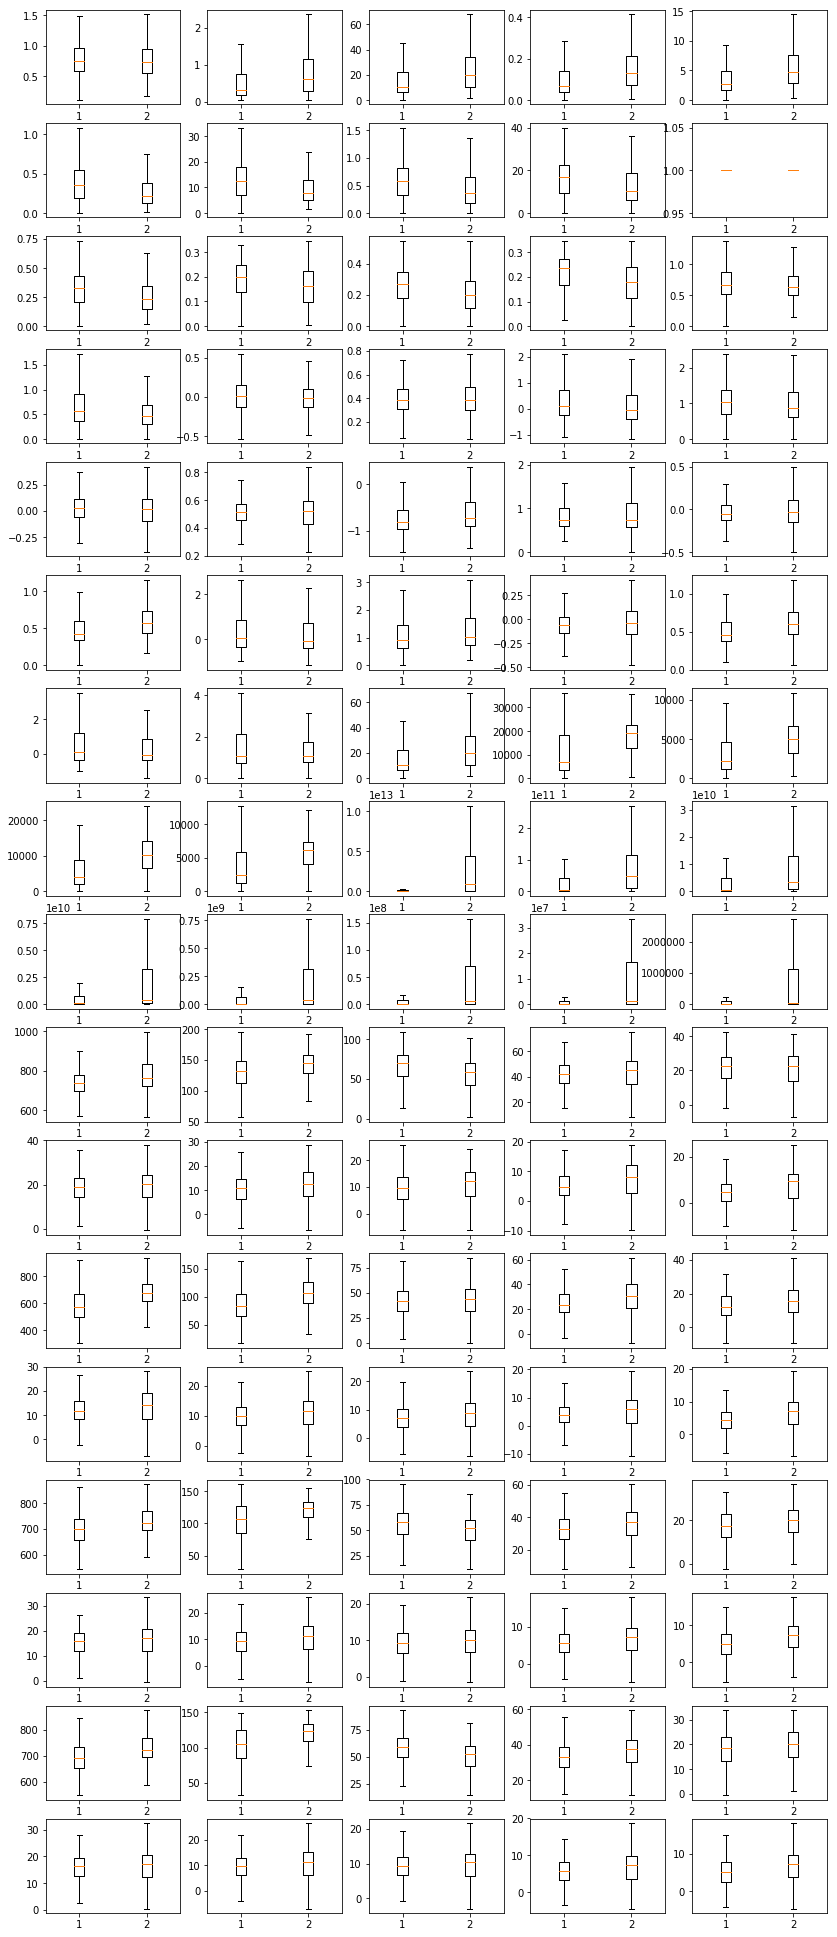

In [5]:
fig = plt.figure(figsize=(14,35))
for i in range(85):
    ax = fig.add_subplot(17,5,i+1)
    ft = dataset[:,i]
    normalft = ft[labels==1]
    anormalft = ft[labels==-1]
    ax.boxplot([normalft, anormalft], showfliers=False)

Nous pouvons tirer la même conclusion que lors de l'observation des histogrammes. Une réduction de dimension dans la suite du projet sera essentielle

## 4. Classification

Dans cette partie, nous allons appliquer des algorithmes de Machine Learning à nos features afin de détecter si un coeur est sain ou malade. <br>
Nos modèles benchmark sont les suivants : modèle qui prédit qu'un coeur est toujours normal, son opposé qui prédit qu'un coeur est toujours malade ainsi que le modèle Logit. Nous utilisons également des modèles plus sophistiqués comme une Random Forest, un SVM ou encore un Extra Trees. <br>
Par la suite, nous sélectionnerons les deux meilleurs modèles sur lesquels nous procéderons à une optimisation des hyperparamètres afin d'améliorer leurs performances. Nous testerons sur un échantillon test les modèles ainsi optimisés et nous nous intéresserons à leurs erreurs et désaccords. <br>
Enfin, nous nous sommes intéressés à l'émergence de nouveaux algorithmes qui pourraient être appliqués à notre problème de classification comme le lightgbm.

In [3]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,roc_curve, auc

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
X,Xtest,labels_train,labels_test = train_test_split(dataset,labels,test_size = 0.2,random_state=0)

In [8]:
labels_test.shape

(220,)

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtest = scaler.transform(Xtest)

### 4.1 Benchmark
Nous commençons donc par considérer des modèles simples afin de voir si des modèles plus complexes sont plus performants.

#### 4.1.1 Analyse en composantes principales

In [11]:
pca = PCA(n_components = 20)

In [12]:
xtrain,xtest,ytrain,ytest = train_test_split(X,labels_train,test_size = 0.3)
xtrain_red = pca.fit_transform(xtrain)
xtest_red = pca.transform(xtest)

La proportion de variance expliquée est 0.88


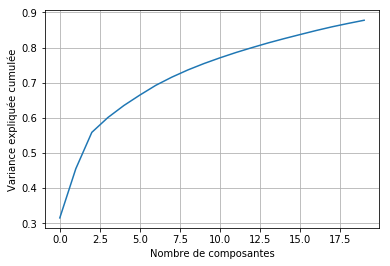

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
print('La proportion de variance expliquée est %0.2f'%np.sum(pca.explained_variance_ratio_))

Avec 20 variables uniquement, nous expliquons une grande partie de la variance des features. Nous allons donc continuer avec uniquement ces 20 variables.

#### 4.4.2 Evaluation de certains modèles standards

In [32]:
logit = LogisticRegression(random_state=0)
nn = MLPClassifier(random_state=0)
dtree = DecisionTreeClassifier(random_state=0)
svm = SVC(random_state=0)
gradb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ET = ExtraTreesClassifier(random_state=0)
adab = AdaBoostClassifier(random_state=0)
classifiers_list = ['hasard',
                    'toujours sain',
                    'toujours malade',
                    'régression logisitique',
                    'réseau de neurones',
                    'arbre de decision',
                    'SVM',
                    'Gradient Boosting',
                    'Random Forest',
                    'Extra Trees',
                    'AdaBoost']
results = np.array([[.5,.5],
                    [0,np.sum(ytest==1)/ytest.shape[0]],
                    [1,np.sum(ytest==-1)/ytest.shape[0]]])

for i,clf in enumerate([logit,nn,dtree,svm,gradb,rf,ET,adab]):
    clf.fit(xtrain_red,ytrain)
    ypred = clf.predict(xtest_red)
    recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
    accuracy = accuracy_score(ytest,ypred)
    results = np.row_stack((results,np.array([recall,accuracy])))

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [33]:
results_df = pd.DataFrame(results,columns=['recall','accuracy'],index=classifiers_list)
results_df.round(2)

,recall,accuracy
hasard,0.50,0.50
toujours sain,0.00,0.44
toujours malade,1.00,0.56
régression logisitique,0.74,0.71
réseau de neurones,0.77,0.71
arbre de decision,0.62,0.64
SVM,0.81,0.72
Gradient Boosting,0.77,0.69
Random Forest,0.79,0.72
Extra Trees,0.83,0.69


**Conclusion:** deux modèles se démarquent particulièrement: le **SVM** et le **Extra Trees** (bien que le deuxième soit proche en terme de scores de la Random Forest). Ce sont donc ces deux modèles que nous allons optimiser dans la suite. 

### 4.2 Optimisation des hyperparamètres du SVM

Les paramètres de pénalité (C) et $\gamma$ (gamma) sont déterminants pour l'efficacité du SVM. La normalisation des données aussi. Nous allons rechercher la meilleure performance que l'on peut obtenir avec cet algorithme en jouant uniquement sur ces deux hyperparamètres.

En particulier, *on ne peut pas se contenter de maximiser le recall*: avec un mauvais réglage, le SVM se comporterait comme un "dummy", c'est-à-dire qu'il prédirait par exemple "toujours malade". Le recall serait alors de 1, mais la solution ne serait bien sûr par satisfaisante. Par conséquent, nous allons parcourir une *échelle logarithmique* pour C et gamma et retenir les paramètres qui nous donnent le meilleur compromis.

In [27]:
pca = PCA(n_components=20)

In [72]:
xtrain,xtest,ytrain,ytest = train_test_split(X,labels_train,test_size = 0.3,random_state=0)
xtrain_red = pca.fit_transform(xtrain)
xtest_red = pca.transform(xtest)

In [81]:
log_range = [1e-3,0.01,0.1,1,10,100,1000] #les différentes valeurs qui seront testées pour C et gamma
res_recall = np.zeros(7)
res_accuracy = np.zeros(7)
for valueC in log_range:
    intermediate_res_recall = []
    intermediate_res_accuracy = []
    for value_gamma in log_range:
        svm = SVC(C=valueC,gamma=value_gamma,random_state=0)
        svm.fit(xtrain_red,ytrain)
        ypred = svm.predict(xtest_red)
        accuracy = accuracy_score(ytest,ypred)
        recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
        intermediate_res_recall.append(recall)
        intermediate_res_accuracy.append(accuracy)
    res_recall = np.row_stack((res_recall,np.array(intermediate_res_recall)))
    res_accuracy = np.row_stack((res_accuracy,np.array(intermediate_res_accuracy)))
res_recall = res_recall[1:]
res_accuracy = res_accuracy[1:]

On obtient le tableau suivant pour les scores de recall:

In [82]:
df = pd.DataFrame(res_recall,columns=['gamma='+str(v) for v in log_range],index=['C='+str(v) for v in log_range])
df.round(2)

,gamma=0.001,gamma=0.01,gamma=0.1,gamma=1,gamma=10,gamma=100,gamma=1000
C=0.001,1.00,1.00,1.00,1.0,1.0,1.0,1.0
C=0.01,1.00,1.00,1.00,1.0,1.0,1.0,1.0
C=0.1,1.00,0.84,1.00,1.0,1.0,1.0,1.0
C=1,0.84,0.88,0.90,1.0,1.0,1.0,1.0
C=10,0.86,0.80,0.77,1.0,1.0,1.0,1.0
C=100,0.82,0.69,0.77,1.0,1.0,1.0,1.0
C=1000,0.74,0.70,0.77,1.0,1.0,1.0,1.0


Et on obtient le tableau suivant pour les scores d'accuracy:

In [83]:
df = pd.DataFrame(res_accuracy,columns=['gamma='+str(v) for v in log_range],index=['C='+str(v) for v in log_range])
df.round(2)

,gamma=0.001,gamma=0.01,gamma=0.1,gamma=1,gamma=10,gamma=100,gamma=1000
C=0.001,0.50,0.50,0.50,0.5,0.5,0.5,0.5
C=0.01,0.50,0.50,0.50,0.5,0.5,0.5,0.5
C=0.1,0.51,0.68,0.51,0.5,0.5,0.5,0.5
C=1,0.71,0.71,0.70,0.5,0.5,0.5,0.5
C=10,0.72,0.68,0.66,0.5,0.5,0.5,0.5
C=100,0.69,0.64,0.66,0.5,0.5,0.5,0.5
C=1000,0.66,0.65,0.66,0.5,0.5,0.5,0.5


De façon plus visuelle:

Text(0,0.5,'accuracy')

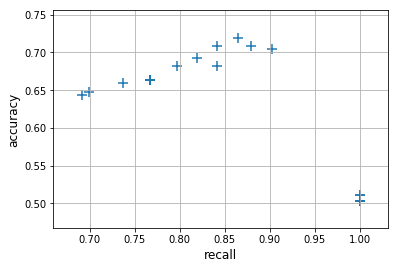

In [84]:
plt.scatter(res_recall,res_accuracy,marker='+',s=100)
plt.grid(True)
plt.xlabel('recall',fontsize=12)
plt.ylabel('accuracy',fontsize=12)
#plt.xlim([0,1.05])
#plt.ylim([0,1])

Le meilleur des recall parmi ceux où le SVM ne se comporte pas comme un "dummy" vaut **0.90** et l'accuracy correspondante vaut **0.70** (ce qui est quasiment la meilleure accuracy obtenue). Les paramètres optimaux sont donc gamma = 0.1 et C = 1.

### 4.3 Optimisation des hyperparamètres de Extra Trees

Nous allons procéder par cross validation pour choisir les meilleurs hyperparamètres pour le modèle retenu. Le but étant maintenant d'obtenir le meilleur score en recall possible, tout en ne perdant pas trop en accuracy. <br>
A la différence du SVM, nous allons optimiser bien plus de deux hyperparamètres, nous ne pouvons donc pas procéder de la même façon que dans la partie 4.2. Pour réaliser l'arbitrage entre accuracy et recall, nous allons calculer un score composite. <br> Ainsi, nous allons donc maximiser le score F1, avec $$F1=2 \frac{precision*recall}{precision+recall} $$ 
Nous allons utiliser pour cela la bibliothèque **hyperopt**.

In [89]:
from hyperopt import hp,fmin,tpe,space_eval

In [79]:
from sklearn.model_selection import KFold

In [85]:
kf = KFold(n_splits=5,random_state=0)

In [86]:
pca = PCA(n_components=20)

Le score final est calculé comme la moyenne de 5 scores obtenus par validation croisée.

In [98]:
def objective_functionET(params):
    scores = []
    pca_fitted = False
    del params['clf_type']
    for train_index,test_index in kf.split(X,labels_train):
        model = ExtraTreesClassifier(**params,random_state=0)
        xtrain,ytrain = X[train_index],labels_train[train_index]
        if not pca_fitted:
            xtrain_red = pca.fit_transform(xtrain)
            pca_fitted = True #on ne fit qu'une seule fois la PCA, pour appliquer la même à tous les samples
        else:
            xtrain_red = pca.transform(xtrain)
            
        xtest,ytest = X[test_index],labels_train[test_index]
        xtest_red = pca.transform(xtest)
        
        model.fit(xtrain_red,ytrain)
        scores.append(f1_score(ytest,model.predict(xtest_red),pos_label=-1,average='binary'))
    return 1-np.mean(scores) #la fonction objectif sera minimisée, et on veut maximiser le recall

On définit l'espace d'exploration:

In [99]:
space = hp.choice('type',[{'clf_type':'Extra Trees',
                           'criterion':hp.choice('crit',['gini','entropy']),
                           'bootstrap':hp.choice('bs',[True,False]),
                           'max_depth': hp.choice('md',[None, 1+hp.randint('md_int', 10)]),
                           'n_estimators': 10+10*hp.randint('ne', 20),
                           'max_features':hp.choice('mf',['log2','sqrt',None])
                           }]
                 )

In [100]:
results = fmin(fn = objective_functionET,
               space = space,
               algo = tpe.suggest,
               max_evals=100)
space_eval(space,results)

{'bootstrap': False,
 'clf_type': 'Extra Trees',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 200}

Quels sont les scores obtenus?

In [101]:
best_params = space_eval(space,results)
del best_params['clf_type']

In [109]:
clf = ExtraTreesClassifier(**best_params,random_state=0)
clf.fit(xtrain_red,ytrain)
ypred = clf.predict(xtest_red)
ypred_prob = clf.predict_proba(xtest_red)[:,1]
recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
accuracy = accuracy_score(ytest,ypred)
print('Pour le meilleur Extra Trees, recall={},accuracy={}'.format(round(recall,2),round(accuracy,2)))

Pour le meilleur Extra Trees, recall=0.88,accuracy=0.72


Ces scores sont ceux obtenus sur la base d'entraînement, et ne sont présentés ici que pour vérifier que maximiser le score f1 ne conduit pas à des valeurs aberrantes en terme de recall et d'accuracy.

### 4.4 Evaluation du meilleur modèle

In [103]:
pca = PCA(n_components=20)

In [104]:
X_red = pca.fit_transform(X)
Xtest_red = pca.transform(Xtest)

In [124]:
acc_tjs_malade = np.sum(labels_test==-1)/len(labels_test)
acc_tjs_sain = np.sum(labels_test==1)/len(labels_test)
print('L\'accuracy des prédicteurs dummy est {} (pour toujours malade) et {} (pour toujours sain)'.format(round(acc_tjs_malade,2),round(acc_tjs_sain,2)))

L'accuracy des prédicteurs dummy est 0.63 (pour toujours malade) et 0.37 (pour toujours sain)


*Nous remarquons que notre base de test est déséquilibrée: il y a plus de malades que de non malades. Les performances de nos algorithmes risquent donc d'être surévaluées.*

#### 4.4.1 Meilleur SVM

Regardons maintenant les performances notre SVM sur la base de test. La normalisation de la base test a été faite en début de partie.

In [155]:
svm = SVC(C=1,gamma=0.1,random_state=0)
svm.fit(X_red,labels_train)
ypred_svm = svm.predict(Xtest_red)
ypred_prob = clf.predict_proba(Xtest_red)[:,1]
recall = recall_score(labels_test,ypred,pos_label=-1,average='binary')
accuracy = accuracy_score(labels_test,ypred)
print('Pour le meilleur SVM, recall={},accuracy={}'.format(round(recall,2),round(accuracy,2)))

Pour le meilleur SVM, recall=0.9,accuracy=0.8


On obtient donc sur la base de test des scores tout à fait comparables à ceux obtenus lors de l'optimisation des hyperparamètres, voire même significativement meilleurs en terme d'accuracy. <br>
Analysons plus largement les performances de notre modèle.

AUC score: 0.629


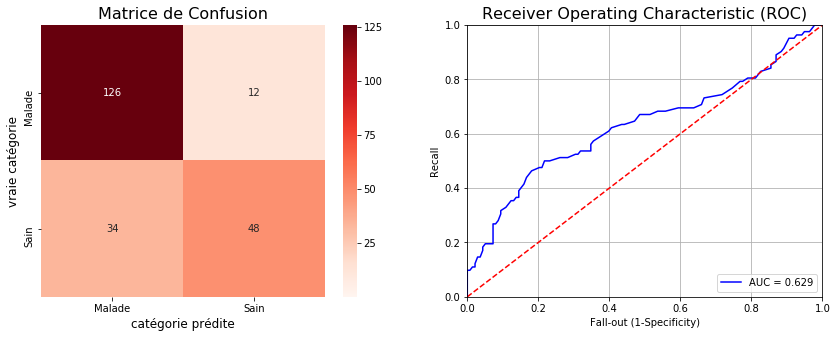

In [156]:
fig = plt.figure(figsize=(14,5))
#CM
ax1 = fig.add_subplot(121)
cm = confusion_matrix(labels_test, ypred_svm)
labels = ['Malade', 'Sain']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", vmin = 0.2);
ax1.set_title('Matrice de Confusion',fontsize=16)
ax1.set_ylabel('vraie catégorie',fontsize=12)
ax1.set_xlabel('catégorie prédite',fontsize=12)

#ROC curve
ax2 = fig.add_subplot(122)
false_positive_rate, recall, thresholds = roc_curve(labels_test, ypred_prob)
roc_auc = auc(false_positive_rate, recall)
ax2.set_title('Receiver Operating Characteristic (ROC)',fontsize=16)
ax2.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
ax2.legend(loc='lower right')
ax2.plot([0,1], [0,1], 'r--')
ax2.set_xlim([0.0,1.0])
ax2.set_ylim([0.0,1.0])
ax2.set_ylabel('Recall')
ax2.set_xlabel('Fall-out (1-Specificity)')
ax2.grid(True)
print('AUC score: %0.3f'%roc_auc)

#### 4.4.2 Meilleur Extra Trees

On refait les mêmes analyses, cette fois-ci pour notre modèle Extra Trees optimisé.

In [157]:
extraT = ExtraTreesClassifier(**best_params,random_state=0)
extraT.fit(X_red,labels_train)
ypred_et = extraT.predict(Xtest_red)
ypred_prob = extraT.predict_proba(Xtest_red)[:,1]
recall = recall_score(labels_test,ypred,pos_label=-1,average='binary')
accuracy = accuracy_score(labels_test,ypred)
print('Pour le meilleur Extra Trees, recall={},accuracy={}'.format(round(recall,3),round(accuracy,3)))

Pour le meilleur Extra Trees, recall=0.899,accuracy=0.8


AUC score: 0.839


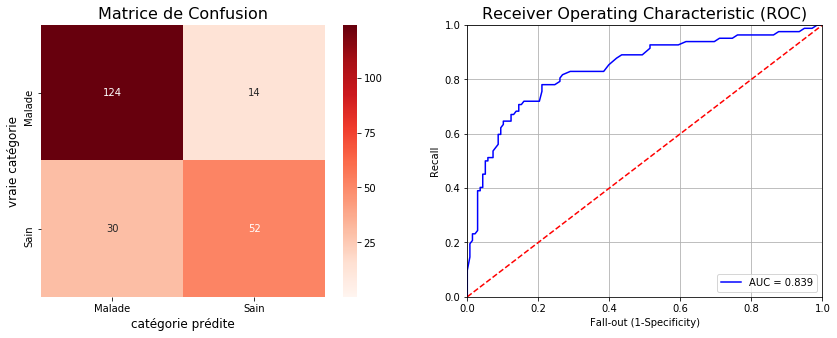

In [158]:
fig = plt.figure(figsize=(14,5))
#CM
ax1 = fig.add_subplot(121)
cm = confusion_matrix(labels_test, ypred_et)
labels = ['Malade', 'Sain']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", vmin = 0.2);
ax1.set_title('Matrice de Confusion',fontsize=16)
ax1.set_ylabel('vraie catégorie',fontsize=12)
ax1.set_xlabel('catégorie prédite',fontsize=12)

#ROC curve
ax2 = fig.add_subplot(122)
false_positive_rate, recall, thresholds = roc_curve(labels_test, ypred_prob)
roc_auc = auc(false_positive_rate, recall)
ax2.set_title('Receiver Operating Characteristic (ROC)',fontsize=16)
ax2.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
ax2.legend(loc='lower right')
ax2.plot([0,1], [0,1], 'r--')
ax2.set_xlim([0.0,1.0])
ax2.set_ylim([0.0,1.0])
ax2.set_ylabel('Recall')
ax2.set_xlabel('Fall-out (1-Specificity)')
ax2.grid(True)
print('AUC score: %0.3f'%roc_auc)

#### 4.4.3 Conclusions

Finalement, les scores obtenus sont tout à fait honorables: **environ 0.9 de recall et 0.8 d'accuracy** dans les deux cas. <br> 
Cependant, les classifieurs ont tendance à prédire trop de coeurs malades, si bien que **les erreurs ne sont pas équitablement réparties** entre erreurs de type I et erreurs de type II. Mais c'est ce que nous souhaitions pour notre classifieur, puisque ne pas voir qu'un coeur est malade est plus grave que de ne pas voir qu'un coeur est sain. <br>
Concernant les courbes ROC, celle du classifieur Extra Trees est bien meilleure que celle du SVM, toutefois le SVM est par construction un mauvais estimateur probabiliste. <br>
Finalement, nous pouvons considérer que le modèle **Extra Trees est plus performant**, de peu, que le SVM.

Comparons rapidement les prédictions des deux modèles, en étudiant leurs cas de désaccord. Nous allons construire des pseudo-matrices de confusion (matrices de confusion en ne prenant en compte que les cas de désaccord).

Text(0.5,24,'prédiction Extra Trees')

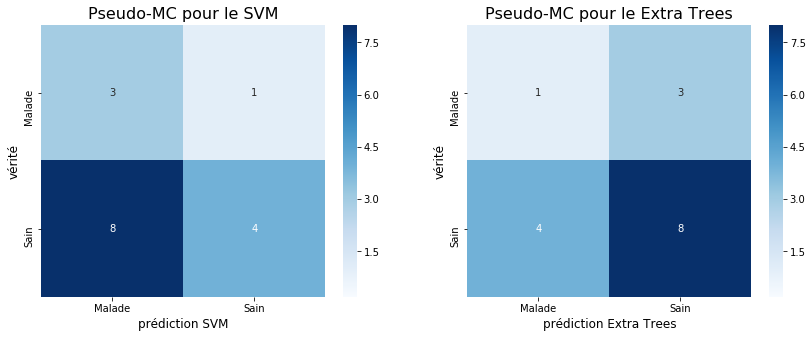

In [185]:
mask = ypred_et!=ypred_svm
disagree_labels = labels_test[mask]
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
cm_svm = confusion_matrix(disagree_labels, ypred_svm[mask],labels=[-1,1])
labels = ['Malade', 'Sain']
sns.heatmap(cm_svm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Pseudo-MC pour le SVM',fontsize=16)
plt.ylabel('vérité',fontsize=12)
plt.xlabel('prédiction SVM',fontsize=12)

ax2 = fig.add_subplot(122)
cm_et = confusion_matrix(disagree_labels, ypred_et[mask],labels=[-1,1])
labels = ['Malade', 'Sain']
sns.heatmap(cm_et, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Pseudo-MC pour le Extra Trees',fontsize=16)
plt.ylabel('vérité',fontsize=12)
plt.xlabel('prédiction Extra Trees',fontsize=12)

Vérifions que les matrices de confusion sont correctement étiquetées

In [184]:
recall_et = recall_score(disagree_labels,ypred_et[mask],pos_label=-1)
recall_svm = recall_score(disagree_labels,ypred_svm[mask],pos_label=-1)
print('le recall du SVM est {} et celui du Extra Trees est {}'.format(recall_svm,recall_et))

le recall du SVM est 0.75 et celui du Extra Trees est 0.25


Les deux modèles ont donc relativement peu de cas de désaccord (16 en tout). Le SVM donne un meilleur recall parmi ces cas de désaccord (0.75 contre 0.25), et le Extra Trees une meilleure accuracy (0.44 contre 0.56).<br>
Cela conforte notre choix de prendre le Extra Trees comme modèle final: nous ne perdons pas vraiment d'information par rapport à ce que donne le SVM (ie nous perdons 7 cas où le SVM a raison sur 16 cas de désaccord).

### 4.5 Supplément: découverte du lightgbm

Durant nos recherches, nous avons remarqué l'existence d'une library que nous ne connaissions pas : lightgbm. Nous allons donc tester ce nouveau package dans cette sous partie. <br>
Nous procéderons à une rapide recherche des meilleurs hyperparamètres, afin de pouvoir comparer avec notre Random Forest optimisée.

In [40]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [95]:
#Hyperparamètres du 1er modèle
params = {'boosting_type': 'gbdt',
          'max_depth' : 50,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 80,
          'learning_rate': 0.07,
          'max_bin': 100,
          'subsample_for_bin': 50,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Hyperparamètres à faire varier
gridParams = {
    'learning_rate': [0.05,0.1,0.2],
    'max_depth' : [5, 10, 20,None],
    'max_bin': [50,100,None],
    'n_estimators': [10, 50, 80],
    'num_leaves': [50, 60, 70, 80],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [0], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1, 1.4, 1.6],
    'reg_lambda' : [ 1.2, 1.4, 1.6],
}

In [96]:
#1er modèle
mdl = lgb.LGBMClassifier(**params,
                         silent = True,
                         )
#On définit une Gridsearch
grid = GridSearchCV(mdl, gridParams,cv=5, n_jobs=-1)
grid.fit(xtrain, ytrain)
#On fait apparaître le meilleur cas
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.2, 'max_bin': 100, 'max_depth': 5, 'n_estimators': 80, 'num_leaves': 50, 'objective': 'binary', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1.4, 'subsample': 0.75}
0.742671009771987


In [97]:
params.update(grid.best_params_)
print('Fitting with params: {}'.format(params))

Fitting with params: {'boosting_type': 'gbdt', 'max_depth': 5, 'objective': 'binary', 'nthread': 5, 'num_leaves': 50, 'learning_rate': 0.2, 'max_bin': 100, 'subsample_for_bin': 50, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1, 'reg_lambda': 1.4, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error', 'n_estimators': 80, 'random_state': 0}


In [98]:
#On réentraine un modèle avec les nouveaux paramètres
train_data = lgb.Dataset(xtrain_red, ytrain)
test_data = lgb.Dataset(xtest_red, label=ytest)
lgbm = lgb.train(params,train_data,verbose_eval=4)

#Predictions
predictions_lgbm_prob = lgbm.predict(xtest_red)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, -1) 
acc_lgbm = accuracy_score(ytest,predictions_lgbm_01)
score_lgbm = recall_score(ytest, predictions_lgbm_01)
print('Accuracy du Light GBM :', acc_lgbm)
print('Recall du Light GBM :', score_lgbm)

Accuracy du Light GBM : 0.7196969696969697
Recall du Light GBM : 0.646551724137931


C:\Users\benoit\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


On remarque que ce nouveau package ne semble pour le moment pas satisfaisant. Nous n'arrivons pas à atteindre le niveau de performance de l'Extra Trees. Cependant, nous aurions pu pousser plus avant notre optimisation, mais la puissance de nos ordinateurs a été un facteur limitant.

## Conclusion

### Aboutissement du projet

Notre meilleur modèle prédictif semble être un Extra Trees, avec lequel nous parvenons à obtenir des scores (accuracy et recall) honorables. Il est à remarquer que ce modèle donne des scores significativement meilleurs que ceux des modèles utilisés pour le benchmark.<br>
Toutefois, son score d'accuracy reste relativement faible et notre modèle paraît peu exploitable en l'état. <br> 
Le coût de l'erreur dans le domaine médical est important, et il est plus grave de diagnostiquer comme "sain" un coeur "malade" que de faire l'erreur inverse. C'est pour cela que nous avons choisi comme indicateur de performance le score de recall, et de ne considérer l'accuracy que dans un deuxième temps. Il est donc crucial d'avoir un excellent score de recall avant d'implémenter l'algorithme dans un cadre opérationnel. <br>
A ce titre, un tel outil pourrait parfaitement devenir un outil consultatif pour les médecins afin de confronter leur avis à celui de l'algorithme. Cependant, il ne peut en rien remplacer le médecin dans le diagnostic final concernant le patient.

### Pistes d'amélioration

Notre modèle peut constituer un socle intéressant et qu'il est possible de l'améliorer, avec plus de temps, de données et de puissance de calcul. Une piste serait par exemple d'améliorer notre méthode de segmentation, par exemple avec une approche orientée clustering plutôt qu'une approche compréhensive. <br> 

### Pistes d'implémentation

De tels algorithmes pourraient être implémentés en collaboration avec des organismes comme l'AP-HP, qui pourraient constituer une base de données conséquente et multicentriques. Nous aurions alors une certaine exigence d'ergonomie: le logiciel devrait être facile à prendre en main pour des médecins qui n'auraient jamais été en contact avec des assistants de diagnostic automatiques. <br>
Dans ce cadre, le modèle serait alors réentraîné régulièrement: en conservant le modèle d'un Extra Trees, on pourrait entraîner le modèle $n+1$ à partir du modèle $n$ (il n'y pas besoin de tout réentraîner depuis le début). <br>
Toutefois, il est primordial de conserver à l'esprit que l'algorithme ne remplace pas le médecin, notamment lorsque l'on en vient à des questions de responsabilité légale. Le rôle de l'algorithme n'est pas de supplanter le médecin, mais d'attirer son attention sur des éléments qu'il pourrait avoir manqué en invitant à un réexamen.

## Bibliographie

Moukadem, A. (2011). Segmentation et classification des signaux non-stationnaires: application au traitement des sons cardiaque et à l'aide au diagnostic (Doctoral dissertation, Université de Haute Alsace-Mulhouse).

Liang, H., Lukkarinen, S., & Hartimo, I. (1997, September). Heart sound segmentation algorithm based on heart sound envelogram. In Computers in Cardiology 1997 (pp. 105-108). IEEE.

Safara, F., Doraisamy, S., Azman, A., Jantan, A., & Ramaiah, A. R. A. (2013). Multi-level basis selection of wavelet packet decomposition tree for heart sound classification. Computers in biology and medicine, 43(10), 1407-1414.

Singh, M., & Cheema, A. (2013). Heart sounds classification using feature extraction of phonocardiography signal. International Journal of Computer Applications, 77(4).

Atbi, A., & Debbal, S. M. (2013). Segmentation of pathological signals phonocardiogram by using the Shannon energy envelogram. AJCM, 2(1), 1-14.